(48, 194)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted digits: [np.int64(5), np.int64(0)]


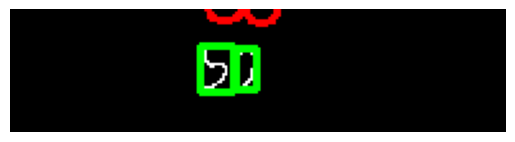

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load pre-trained MNIST model
model = load_model('mnist_cnn.h5')  # Replace with your model path or train one

def preprocess_image(image_path):
    """Load and preprocess the image"""
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    if img is None:
        raise ValueError("Image not found or invalid path")
    
    # Invert and threshold image (assuming black digits on white background)
    img = cv2.bitwise_not(img)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    return thresh

def find_digits(image):
    """Find contours of individual digits in the image"""
    # Find contours
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get bounding boxes for each contour
    digit_rects = [cv2.boundingRect(contour) for contour in contours]
    
    # Sort bounding boxes from left to right
    digit_rects.sort(key=lambda x: x[0])
    
    return digit_rects

def extract_digits(image, digit_rects, padding=5):
    """Extract and preprocess each digit"""
    digits = []
    for rect in digit_rects:
        x, y, w, h = rect
        
        # Add padding around the digit
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(image.shape[1], x + w + padding)
        y_end = min(image.shape[0], y + h + padding)
        
        # Extract the digit
        digit = image[y_start:y_end, x_start:x_end]
        
        # Resize to 28x28 (MNIST standard)
        digit = cv2.resize(digit, (28, 28))
        
        # Normalize pixel values
        digit = digit.astype('float32') / 255.0
        
        # Reshape for model input (add channel dimension)
        digit = np.expand_dims(digit, axis=-1)
        
        digits.append(digit)
    
    return np.array(digits)

def predict_digits(model, digits):
    """Predict digits using the trained model"""
    predictions = model.predict(digits)
    predicted_digits = [np.argmax(pred) for pred in predictions]
    return predicted_digits

def display_results(image, digit_rects, predictions):
    """Display the original image with bounding boxes and predictions"""
    # Convert back to RGB for display
    img_display = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    for rect, pred in zip(digit_rects, predictions):
        x, y, w, h = rect
        
        # Draw rectangle around digit
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Put predicted digit
        cv2.putText(img_display, str(pred), (x, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

def classify_handwritten_digits(image_path):
    """Main function to classify multiple handwritten digits in an image"""
    try:
        # Step 1: Preprocess the image
        processed_img = preprocess_image(image_path)
        
        # Step 2: Find individual digits
        digit_rects = find_digits(processed_img)
        
        if not digit_rects:
            print("No digits found in the image.")
            return
        
        # Step 3: Extract and prepare each digit
        digits = extract_digits(processed_img, digit_rects)
        
        # Step 4: Predict digits
        predictions = predict_digits(model, digits)
        
        print("Predicted digits:", predictions)
        
        # Step 5: Display results
        display_results(processed_img, digit_rects, predictions)
        
        return predictions
        
    except Exception as e:
        print(f"Error: {e}")

# Example usage
if __name__ == "__main__":
    image_path = "imageForTesting\\16.png"  # Replace with your image path
    classify_handwritten_digits(image_path)

In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build model
model = Sequential([
    # Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # MaxPooling2D((2, 2)),
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    # Flatten(),
    # Dense(128, activation='relu'),
    # Dense(10, activation='softmax')
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Save model
model.save('mnist_cnn.h5')

Epoch 1/5


c:\gen232\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8849 - loss: 0.3880 - val_accuracy: 0.9861 - val_loss: 0.0405
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9795 - loss: 0.0671 - val_accuracy: 0.9919 - val_loss: 0.0245
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9855 - loss: 0.0473 - val_accuracy: 0.9926 - val_loss: 0.0226
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9867 - loss: 0.0407 - val_accuracy: 0.9935 - val_loss: 0.0186
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9883 - loss: 0.0355 - val_accuracy: 0.9931 - val_loss: 0.0199
